In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta


In [2]:
!pip install xlrd==2.0.1


Defaulting to user installation because normal site-packages is not writeable


In [2]:
df = pd.read_excel('spane4all_followers_1759344331382.xls')

In [3]:
df.head()

,Date,Sponsored followers,Organic followers,Auto-invited followers,Total followers
0,09/30/2024,0.0,0.0,0,0
1,10/01/2024,0.0,1.0,0,1
2,10/02/2024,0.0,0.0,0,0
3,10/03/2024,0.0,1.0,0,1
4,10/04/2024,0.0,0.0,0,0


In [5]:
df.columns

Index(['Date', 'Sponsored followers', 'Organic followers',
       'Auto-invited followers', 'Total followers'],
      dtype='object')

In [6]:
#renaming the columns for convenience
df.columns =['Date','Sponsored','Organic','Auto_invited','Total']

In [7]:
df['Date']= pd.to_datetime(df['Date']) # pesing the date

In [8]:
#sorting just incase
df = df.sort_values('Date').reset_index(drop=True)

In [9]:
#Nowfixing the single negetive value (31 Dec 2024)
df.loc[df['Total']<0, 'Total']=0

# NOW I DO EDA FOR MY DATA

In [29]:
print('======DAILY ADDS SUMMARY=========')
print(df['Total'].describe())

======DAILY ADDS SUMMARY=========
count     366.000000
mean       12.964481
std       123.939032
min         0.000000
25%         1.000000
50%         4.000000
75%         9.000000
max      2372.000000
Name: Total, dtype: float64


In [11]:
#cumulative followerscolumn
df['Cumu_followers'] = df['Total'].cumsum()

In [12]:
df.head(5)

,Date,Sponsored,Organic,Auto_invited,Total,Cumu_followers
0,2024-09-30,0.0,0.0,0,0,0
1,2024-10-01,0.0,1.0,0,1,1
2,2024-10-02,0.0,0.0,0,0,1
3,2024-10-03,0.0,1.0,0,1,2
4,2024-10-04,0.0,0.0,0,0,2


In [13]:
#zero against non zero days
zero_days = (df['Total']==0).sum()

In [14]:
print(f'\nZero followers days are : {zero_days}/{len(df)} which is:{zero_days/len(df):1%}')


Zero followers days are : 79/366 which is:21.584699%


In [15]:
#monthly aggrigation 
df['Month'] = df['Date'].dt.to_period('M')
monthly = df.groupby('Month')['Total'].sum()
print('\n=== MONTHLY NEW FOLLOWERS ======')
print(monthly)


=== MONTHLY NEW FOLLOWERS ======
Month
2024-09      0
2024-10      9
2024-11     33
2024-12     79
2025-01     32
2025-02     55
2025-03    306
2025-04    254
2025-05    312
2025-06    415
2025-07    491
2025-08    235
2025-09    152
Freq: M, Name: Total, dtype: int64


In [16]:
df.columns = df.columns.str.strip()


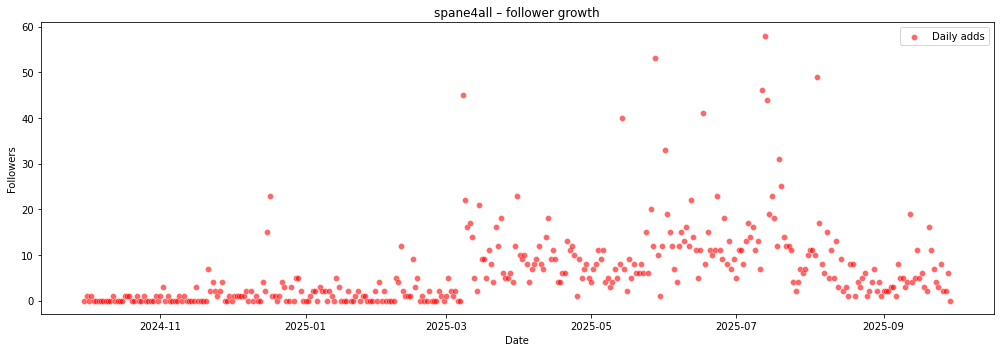

In [17]:
plt.figure(figsize=(14,5))
sns.scatterplot(x='Date', y='Total', data=df, color='red', alpha=.6, label='Daily adds')
plt.title('spane4all – follower growth')
plt.xlabel('Date')
plt.ylabel('Followers')
plt.legend()
plt.tight_layout()
plt.show()


# Linear Regression 

In [18]:
#Feature matrix: day numbers are 1... N
df['FM']= np.arange(1,len(df)+1)

X = df[['FM']]
Y = df['Cumu_followers']

model= LinearRegression()
model.fit(X,Y)

print('===== Linear Regression =====')
print(f'Slope of avarage new followers per day: { model.coef_[0]:.2f}')
print(f'R**2 on training data: {model.score(X,Y):.2f}')
print(f'Intercept : {model.intercept_:.2f}')

===== Linear Regression =====
Slope of avarage new followers per day: 7.50
R**2 on training data: 0.88
Intercept : -548.27


# Projection for 31 Dec 2025

In [19]:
last_day= df['Date'].max()
target_date= datetime(2025,12,31)
delta_day = ( target_date - last_day).days

In [20]:
future_time = np.array([[len(df) + delta_day]])
projected_total = int(model.predict(future_time)[0])

/home/moeletsi/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [22]:
print('\n===== Projection =====')
print(f'Last data point:  {last_day.date()}  ->  {int(df["Cumu_followers"].iloc[-1])} followers')
print(f'Target date : {target_date}')
print(f'Expected new followers : ~ {projected_total}')


===== Projection =====
Last data point:  2025-09-29  ->  4745 followers
Target date : 2025-12-31 00:00:00
Expected new followers : ~ 2896


In [23]:
total_followers = (projected_total + int(df['Cumu_followers'].iloc[-1]))
print("========= TOTAL AMOUNT OF FOLLOWERS TO EXPECT ON 31 DEC 2025 ==========")
print(" Linear Regrssion prediction ")
print(f'We should expect to have about ~ {total_followers} on the 31 December 2025 ')

========= TOTAL AMOUNT OF FOLLOWERS TO EXPECT ON 31 DEC 2025 ==========
 Linear Regrssion prediction 
We should expect to have about ~ 7641 on the 31 December 2025 


In [26]:
# Confidence band: ±1 std of residuals (very rough)
residuals = Y - model.predict(X)
std_err = residuals.std()
print(f'Rough 68 % band: {projected_total - int(std_err)} – {projected_total + int(std_err)} for the amout of new follower expected')

Rough 68 % band: 2604 – 3188 for the amout of new follower expected


In [27]:
from prophet import Prophet

ImportError: cannot import name 'Prophet' from partially initialized module 'prophet' (most likely due to a circular import) (/home/moeletsi/Documents/Hitek/Database/October/Dataa/prophet.py)

In [ ]:
#preparing data for prophet ('ds' and 'y')
prophet_df = df[['Date','Cumu_followers']].copy()
prophet_df.columns = ['ds','y']

In [25]:
#initiaizing and fitting the model
model_prophet = Prophet(yearly_seasonality=True,
                        weekly_seasonality= True,
                        daily_seasonality= False,
                       changepoint_prior_scale= 0.05 #regularization to avoid overfitting
                       )

In [26]:
model_prophet.fit(prophet_df)

08:28:07 - cmdstanpy - INFO - Chain [1] start processing
08:28:07 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
future = model_prophet.make_future_dataframe(periods= delta_day)
forecast = model_prophet.predict(future)

In [28]:
#extracting the prediction for our target date
prophet_prediction = forecast[forecast['ds']== target_date]['yhat'].values[0]

In [29]:
# Now let's run the linear regression again for comparison
df['FM'] = np.arange(1, len(df) + 1)
X = df[['FM']]
Y = df['Cumu_followers']

model_lr = LinearRegression()
model_lr.fit(X, Y)

future_time = np.array([[len(df) + delta_day]])
lr_prediction = model_lr.predict(future_time)[0]

/home/moeletsi/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [30]:
# Calculate confidence intervals for both models
# For linear regression
residuals = Y - model_lr.predict(X)
std_err_lr = residuals.std()
lr_lower = lr_prediction - std_err_lr
lr_upper = lr_prediction + std_err_lr
print(residuals)
print(f'Std err: {std_err_lr}')
print(lr_lower)
print(lr_upper)


0      467.108601
1      462.251599
2      457.394597
3      451.537595
4      449.680593
          ...    
360    549.587900
361    551.730898
362    553.873896
363    549.016894
364    547.159892
Name: Cumu_followers, Length: 365, dtype: float64
Std err: 284.0552909495048
2154.9090738570335
2723.0196557560434


In [31]:
# For Prophet (it provides its own uncertainty intervals)
prophet_lower = forecast[forecast['ds'] == target_date]['yhat_lower'].values[0]
prophet_upper = forecast[forecast['ds'] == target_date]['yhat_upper'].values[0]

In [32]:
# Create comparison plot
plt.figure(figsize=(14, 8))


# Convert to numpy arrays for plotting to avoid the pandas indexing issue
dates_np = df['Date'].values
cumulative_np = df['Cumu_followers'].values



<Figure size 1008x576 with 0 Axes>

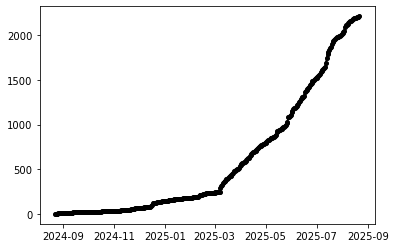

In [33]:
# Plot historical data
plt.plot(dates_np, cumulative_np, 'ko-', label='Historical Data', markersize=4)


/home/moeletsi/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


AttributeError: module 'matplotlib.pyplot' has no attribute 'xtickscksicksicksicksicksi'

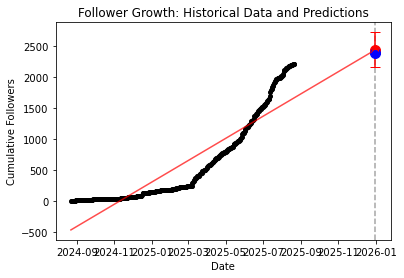

In [34]:

# Historical data
plt.plot(dates_np, cumulative_np, 'ko-', label='Historical Data', markersize=4)

# Plot linear regression prediction
plt.axvline(x=target_date, color='gray', linestyle='--', alpha=0.7, label='Last Data Point')
plt.plot(target_date, lr_prediction, 'ro', markersize=10, label='Linear Regression Prediction')
plt.errorbar(target_date, lr_prediction, yerr=std_err_lr, fmt='o', color='red', 
             capsize=5, label='LR Confidence Interval')

# Plot Prophet prediction
plt.plot(target_date, prophet_prediction, 'bo', markersize=10, label='Prophet Prediction')
plt.errorbar(target_date, prophet_prediction, 
             yerr=[[prophet_prediction - prophet_lower], [prophet_upper - prophet_prediction]], 
             fmt='o', color='blue', capsize=5, label='Prophet Confidence Interval')

##=======
# Plot Prophet forecast
future_dates = forecast[forecast['ds'] > target_date]['ds'].values
future_values = forecast[forecast['ds'] > target_date]['yhat'].values
plt.plot(future_dates, future_values, 'b-', alpha=0.7, label='Prophet Forecast')


# Plot linear regression trendline
all_dates = pd.date_range(start=df['Date'].min(), end=target_date)
all_days = np.arange(1, len(all_dates) + 1)
lr_trend = model_lr.predict(all_days.reshape(-1, 1))
plt.plot(all_dates.values, lr_trend, 'r-', alpha=0.7, label='Linear Regression Trend')

plt.title('Follower Growth: Historical Data and Predictions')
plt.xlabel('Date')
plt.ylabel('Cumulative Followers')
plt.xtickscksicksicksicksicksi
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()





In [ ]:
# Print comparison results
print("="*60)
print("FOLLOWER PREDICTION COMPARISON")
print("="*60)
print(f"Target Date: {target_date.strftime('%Y-%m-%d')}")
print(f"Last data point: {last_day.strftime('%Y-%m-%d')} -> {int(df['Cumu_followers'].iloc[-1])} followers")
print("\nLinear Regression Prediction:")
print(f"  Expected followers: {lr_prediction:.0f}")
print(f"  Confidence interval: {lr_lower:.0f} - {lr_upper:.0f} (68%)")
print(f"  R² on training data: {model_lr.score(X, Y):.3f}")

print("\nProphet Prediction:")
print(f"  Expected followers: {prophet_prediction:.0f}")
print(f"  Confidence interval: {prophet_lower:.0f} - {prophet_upper:.0f} (80% - Prophet default)")
print("\nDifference:")
print(f"  Absolute: {abs(lr_prediction - prophet_prediction):.0f} followers")
print(f"  Relative: {abs(lr_prediction - prophet_prediction)/lr_prediction*100:.1f}%")


In [ ]:
# Check residuals pattern for linear regression
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(model_lr.predict(X), residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Linear Regression Residuals vs Fitted')

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Linear Regression Residuals')
plt.tight_layout()
plt.show()


In [ ]:

# Calculate and compare model performance on historical data
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Prophet predictions on historical data
prophet_historical = forecast[forecast['ds'].isin(df['Date'])]['yhat'].values


In [ ]:

# Calculate metrics
lr_mae = mean_absolute_error(Y, model_lr.predict(X))
lr_rmse = np.sqrt(mean_squared_error(Y, model_lr.predict(X)))

prophet_mae = mean_absolute_error(Y, prophet_historical)
prophet_rmse = np.sqrt(mean_squared_error(Y, prophet_historical))


print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON (HISTORICAL DATA)")
print("="*60)
print(f"Linear Regression:")
print(f"  MAE: {lr_mae:.2f}")
print(f"  RMSE: {lr_rmse:.2f}")

print(f"\nProphet:")
print(f"  MAE: {prophet_mae:.2f}")
print(f"  RMSE: {prophet_rmse:.2f}")



In [ ]:
# Recommendation based on results
print("\n" + "="*60)
print("RECOMMENDATION")
print("="*60)
if prophet_rmse < lr_rmse:
    print("Prophet model performs better on historical data.")
    print(f"Recommended prediction: {prophet_prediction:.0f} followers")
else:
    print("Linear regression performs better on historical data.")
    print(f"Recommended prediction: {lr_prediction:.0f} followers")

In [ ]:
future_dates = forecast[forecast['ds'] > target_date]['ds'].values

print(forecast['ds'].min(), forecast['ds'].max())
print("Target date:", target_date)

target_date = pd.to_datetime(target_date)

future_dates = forecast[forecast['ds'] > target_date]['ds']

# Ensure target_date is datetime
target_date = pd.to_datetime(target_date)

# Filter future forecast
future_forecast = forecast[forecast['ds'] > target_date]

# Check if there's data to plot
if not future_forecast.empty:
    future_dates = future_forecast['ds']
    future_values = future_forecast['yhat']
    plt.plot(future_dates, future_values, 'b-', alpha=0.7, label='Prophet Forecast')
else:
    print("⚠️ No future forecast data available beyond target_date.")



In [ ]:
print("Future forecast dates:", future_dates)
print("Future forecast values:", future_values)


In [ ]:
#Monthly Aggregation: Bar Plot
monthly = df.groupby(df['Date'].dt.to_period('M'))['Total'].sum()
monthly.plot(kind='bar', figsize=(12,6), color='skyblue')
plt.title('Monthly New Followers')
plt.ylabel('Followers')
plt.xlabel('Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:

# Historical data
plt.plot(dates_np, cumulative_np, 'ko-', label='Historical Data', markersize=4)

# Plot linear-regression prediction
plt.axvline(x=target_date, color='gray', linestyle='--', alpha=0.7,
            label='Last Data Point')
plt.plot(target_date, lr_prediction, 'ro', markersize=10,
         label='Linear Regression Prediction')
plt.errorbar(target_date, lr_prediction, yerr=std_err_lr,
             fmt='o', color='red', capsize=5,
             label='LR Confidence Interval')

# Plot Prophet prediction
plt.plot(target_date, prophet_prediction, 'bo', markersize=10,
         label='Prophet Prediction')

# FIXED: give errorbar a 2×N array for asymmetric intervals
prophet_err = np.array([[prophet_prediction - prophet_lower],
                        [prophet_upper - prophet_prediction]])
plt.errorbar(target_date, prophet_prediction, yerr=prophet_err,
             fmt='o', color='blue', capsize=5,
             label='Prophet Confidence Interval')

# Prophet forecast
future_dates = forecast[forecast['ds'] > target_date]['ds'].values
future_values = forecast[forecast['ds'] > target_date]['yhat'].values
plt.plot(future_dates, future_values, 'b-', alpha=0.7,
         label='Prophet Forecast')

# Linear-regression trendline
all_dates = pd.date_range(start=df['Date'].min(), end=target_date)
all_days = np.arange(1, len(all_dates) + 1)
lr_trend = model_lr.predict(all_days.reshape(-1, 1))
plt.plot(all_dates.values, lr_trend, 'r-', alpha=0.7,
         label='Linear Regression Trend')

# --- labels, legend, grid ----------------------------------------------------
plt.title('Follower Growth: Historical Data and Predictions')
plt.xlabel('Date')
plt.ylabel('Cumulative Followers')
plt.legend()
plt.grid(True, alpha=0.3)

# ROTATE x-axis labels 45° ----------------------------------------------------
plt.gca().tick_params(axis='x', rotation=45)

# make sure the rotated labels fit nicely
plt.tight_layout()
plt.show()